In [2]:
# Import necessary packages and libraries
import torchvision
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt


# Load pre-trained model
vgg_model = torchvision.models.vgg16(pretrained=True)

# transformation for passing image into the network
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# selecting layers from the model to generate activations
image_to_heatmaps = nn.Sequential(*list(vgg_model.features[:-4]))

c:\Users\34658\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\34658\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def compute_heatmap(model,img):
  model.eval()
  # compute logits from the model
  logits = model(img)
  # model's prediction 
  pred = logits.max(-1)[-1]
  # activations from the model
  activations = image_to_heatmaps(img)
  # compute gradients with respect to the model's most confident prediction
  logits[0, pred].backward(retain_graph=True)
  # average gradients of the featuremap 
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # calculate mean of weighted activations
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, pred

In [4]:
def upsampleHeatmap(map, image):
  # permute image
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # maximum and minimum value from heatmap
  m, M = map.min(), map.max()
  # normalize the heatmap
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # resize the heatmap to the same as the input
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # change this to balance between heatmap and image
  map = np.uint8(map*0.7 + image*0.3)
  return map

In [5]:

def display_images(upsampled_map, image):
    image = image.squeeze(0).permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(upsampled_map)
    axes[0].set_title("Heatmap")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: tensor([669])


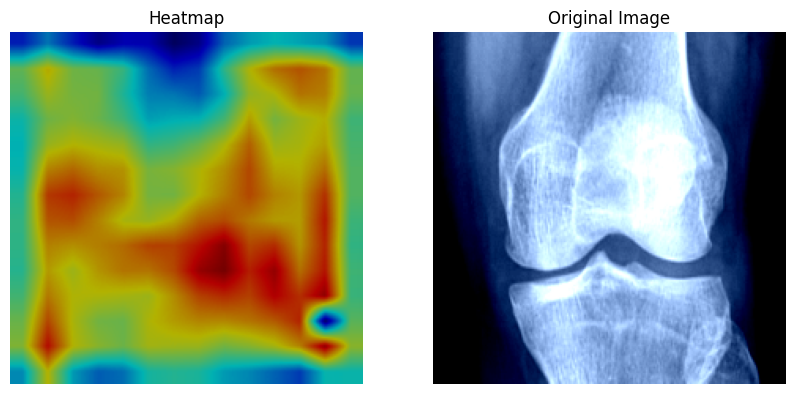

In [8]:
# Example usage
# Load an image
normal_knee = r"dataset\mendeley_dataset\MedicalExpert-I\0\NormalG0 (1).png"
normal_knee = Image.open(normal_knee)
normal_knee = transform(normal_knee)

normal_knee = normal_knee.unsqueeze(0)
heatmap,pred = compute_heatmap(vgg_model,normal_knee)
upsampled_map = upsampleHeatmap(heatmap, normal_knee)
print(f"Prediction: {pred}")

display_images(upsampled_map, normal_knee)